<a href="https://colab.research.google.com/github/HuuDatDo/AI-project/blob/main/Simple_Graph_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import networkx as nx
import torch
import matplotlib.pyplot as plt

In [43]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

In [44]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [45]:
#Visualization of graph
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [46]:
data=dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


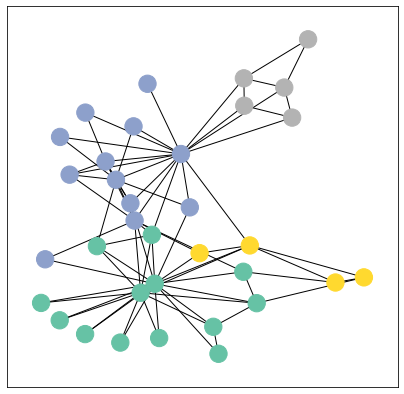

In [47]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(data,color=data.y)

In [48]:
import torch.nn as nn
import torch_geometric.nn as gnn

class GCN(nn.Module):
    def __init__ (self,in_channels,hidden_channels,out_channels):
        super(GCN,self).__init__()
        torch.manual_seed(42)
        self.classifier=nn.Linear(out_channels,dataset.num_classes)
        self.gcn1=gnn.GCNConv(in_channels,hidden_channels)
        self.gcn2=gnn.GCNConv(hidden_channels,hidden_channels)
        self.gcn3=gnn.GCNConv(hidden_channels,out_channels)
        self.activation=nn.ReLU(inplace=False)
        self.dropout=nn.Dropout(p=0.2,inplace=False)

    def forward(self,x,adj):
        x=self.gcn1(x,adj)
        x=self.activation(x)
        x=self.dropout(x)
        x=self.gcn2(x,adj)
        x=self.activation(x)
        x=self.dropout(x)
        x=self.gcn3(x,adj)
        embeddings = torch.tanh(x)
        x=self.classifier(embeddings)
        x=nn.functional.log_softmax(x,dim=1)
        return x,embeddings

model=GCN(34,4,2)
print(model)

GCN(
  (classifier): Linear(in_features=2, out_features=4, bias=True)
  (gcn1): GCNConv(34, 4)
  (gcn2): GCNConv(4, 4)
  (gcn3): GCNConv(4, 2)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


Embedding shape: [34, 2]


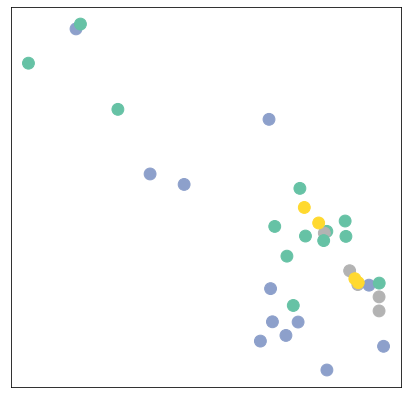

In [49]:
g, h = model(data.x, data.edge_index)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

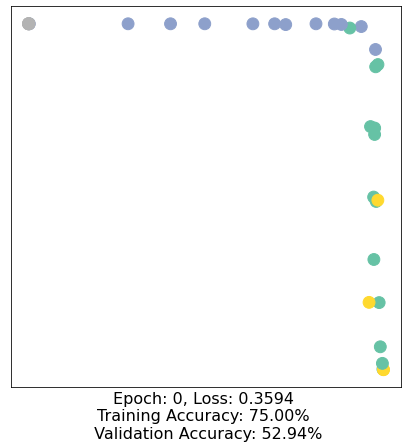

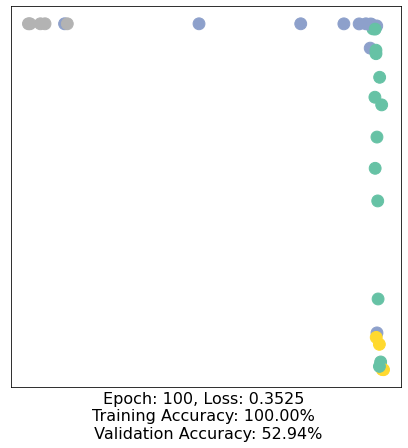

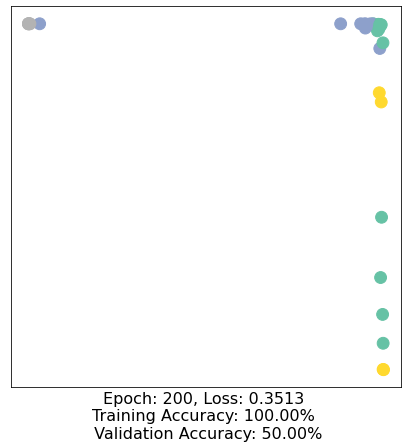

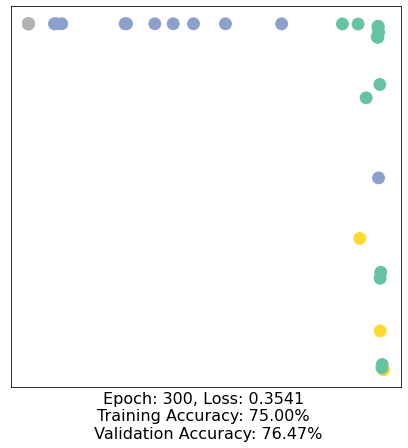

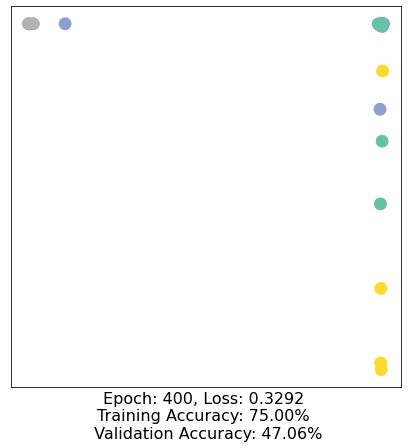

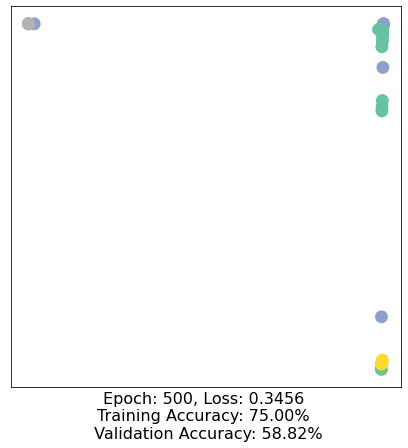

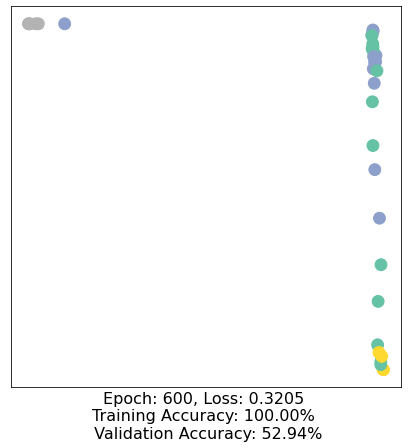

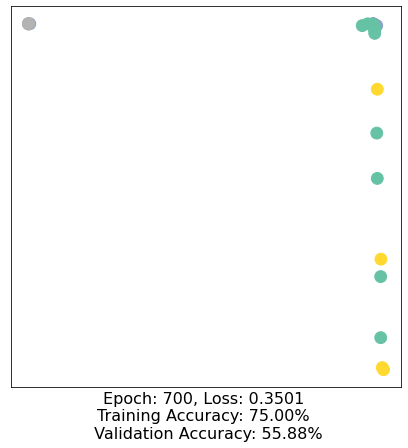

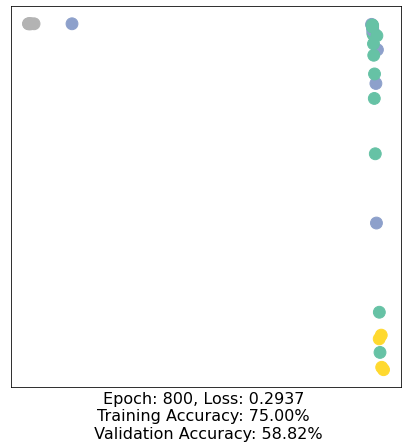

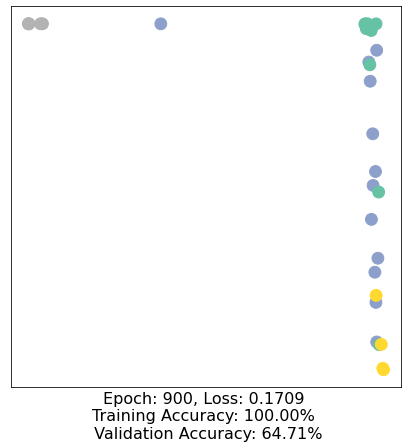

In [51]:
def training(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(1000):
    loss, h, accuracy = training(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 100 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)